Importing Libraries

### Image Captioning Using CNN and LSTM

## Requirements

In [1]:
import tensorflow
import keras
import string
import matplotlib.pyplot as plt
import numpy as np
import spacy
from spacy import tokenizer
from bs4 import BeautifulSoup
import nltk
import string
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
import pandas as pd
from os import listdir
from pickle import dump
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Input, Embedding
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import plot_model

## Connect to Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import a  pre-trained model for feature extraction (Xception)

In [5]:
model_Xception=Sequential()
model_Xception.add(Xception(include_top=False,
                            weights='imagenet',
                            pooling='max'))

model_Xception.add(Dropout(0.2))
model_Xception.add(Dense(2048,activation='relu'))
model_Xception.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2048)              4196352   
                                                                 
Total params: 25,057,832
Trainable params: 25,003,304
Non-trainable params: 54,528
_________________________________________________________________


As we can see in the summary above the output of the model should have to be a flatten array of 2048 parameters representing the image features.

Taking example image from the dataset and print it as a 299x299 pixel and processed properly for the Xception model:

### Image Augumentation

<ipython-input-6-af2a792ea971>:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  input_img = imageio.imread('/content/drive/MyDrive/datasets/data' + '/' + '109823397.jpg')


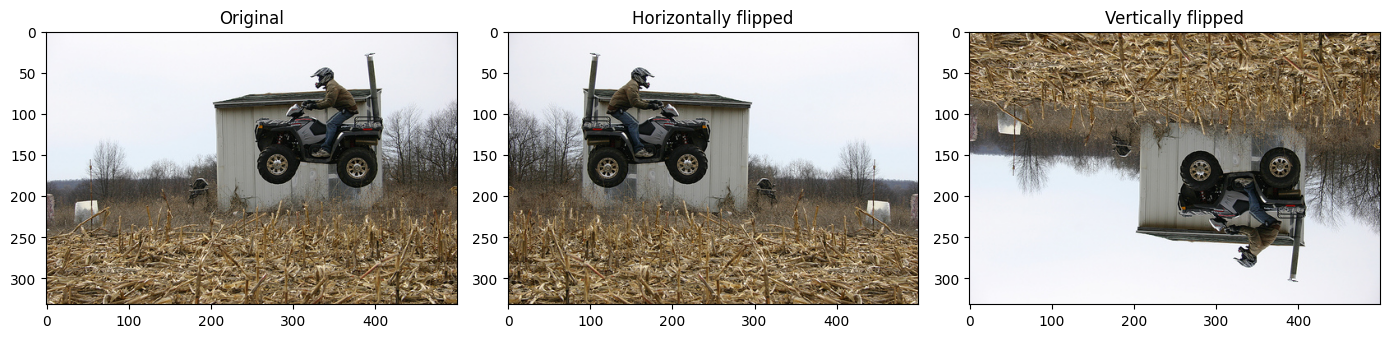

In [6]:
import matplotlib.pyplot as plt
import imageio
import imgaug.augmenters as iaa

input_img = imageio.imread('/content/drive/MyDrive/datasets/data' + '/' + '109823397.jpg')

# Horizontal Flip
hflip = iaa.Fliplr(p=1.0)
input_hf = hflip.augment_image(input_img)

# Vertical Flip
vflip = iaa.Flipud(p=1.0)
input_vf = vflip.augment_image(input_img)

images_list = [input_img, input_hf, input_vf]
labels = ['Original', 'Horizontally flipped', 'Vertically flipped']

# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

# Iterate over the images and labels
for i, (image, label) in enumerate(zip(images_list, labels)):
    ax = axes[i]  # Select the current subplot
    ax.imshow(image)  # Display the image
    ax.set_title(label)  # Set the subplot title

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## Image Pre-Processing using Xception's preprocess_input function

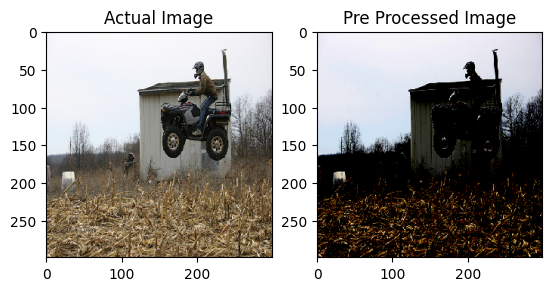

In [7]:
import matplotlib.pyplot as plt

file_loc = '/content/drive/MyDrive/datasets/data' + '/' + '109823397.jpg';
input_image = load_img(file_loc, target_size=(299, 299))
sample_image = img_to_array(input_image)
sample_image = sample_image.reshape((sample_image.shape[0], sample_image.shape[1], sample_image.shape[2]))
sample_image = preprocess_input(sample_image)

f = plt.figure()
f.add_subplot(1,2, 1)
plt.imshow(input_image)
plt.title('Actual Image')
f.add_subplot(1,2, 2)
plt.imshow(sample_image)
plt.title('Pre Processed Image')
plt.show(block=True)

The function above will handle the reading and processing of all the images present in the directory. Subsequently, we will utilize the CNN model we recently built to extract features from each image. These features will be stored in the form of a dictionary, with the image ID serving as the corresponding key.

preprocess_input function includes the below from keras:

Mean normalization: Subtracting the mean pixel values of the dataset from each pixel in the input image. This helps center the pixel values around zero.

Scaling: Scaling the pixel values by dividing them by a specific value, such as 255. This step is commonly performed to ensure that the pixel values are within a specific range, often between 0 and 1.

Channel reordering: Changing the order of the color channels in the image. This step is necessary when the pre-trained model expects a specific channel ordering, such as RGB (red, green, blue) or BGR (blue, green, red).

Input resizing: Resizing the input image to match the required input dimensions of the pre-trained model. This ensures that the image has the correct shape expected by the model.

Additional model-specific transformations: Some models may require additional preprocessing steps, such as data augmentation or specific data format conversions, to prepare the input data appropriately.

# Extract features from each photo in the directory

In [8]:

def feature_extraction(directory):
    # extract features from each photo
    features = dict()
    image_names = []  # List to store the image names

    for name in listdir(directory):
        # load an image from file
        filename = directory + '/' + name
        image = load_img(filename, target_size=(299, 299))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # prepare the image for the Xception model
        image = preprocess_input(image)
        # get features
        feature = model_Xception.predict(image, verbose=0)
        # get image id
        image_id = name.split('.')[0]
        # store feature
        features[image_id] = feature
        image_names.append(name)  # Append the image name to the list

    return features, image_names

Let's run this function on the directory pointing to the folder containing the images and save the features extracted to a pickle file.

In [9]:
# extract features from all images
directory = '/content/drive/MyDrive/datasets/data';
features,image_names = feature_extraction(directory)
print('Extracted Features: %d' % len(features))
# save to file
dump(features, open('features.pkl', 'wb'))

Extracted Features: 1332


## t-SNE plot to visualize the features of all images

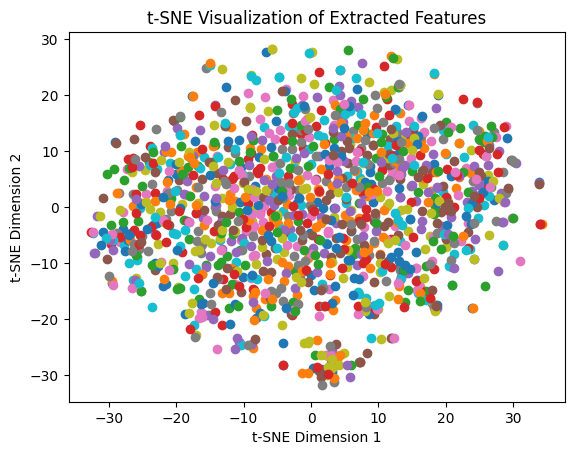

In [10]:
# # Extract the feature values from the dictionary and store them in a list
# feature_values = list(features.values())

# # Convert the list of feature values to a NumPy array
# feature_array = np.array(feature_values)

# # Transpose the feature array
# feature_array = feature_array.transpose()

# # Determine the number of features and images
# num_features = feature_array.shape[0]
# num_images = feature_array.shape[1]

# # Create a figure and subplot for the graph
# fig, ax = plt.subplots()

# # Plot the features for each image as a separate line in the graph
# for i in range(num_images):
#     ax.plot(range(num_features), feature_array[:, i], label='Image {}'.format(i+1))

# # Set labels and title for the graph
# ax.set_xlabel('Feature')
# ax.set_ylabel('Feature Value')
# ax.set_title('Features Extracted from Images')

# # Add a legend to the graph
# # ax.legend()

# # Display the graph
# plt.show()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Extract the feature values from the dictionary and store them in a list
feature_values = list(features.values())

# Convert the list of feature values to a NumPy array
feature_array = np.array(feature_values)

# Reshape the feature array to have shape (num_images * num_features)
feature_array = feature_array.reshape((-1, feature_array.shape[-1]))

# Determine the number of features and images
num_features = feature_array.shape[1]
num_images = feature_array.shape[0]

# Perform t-SNE transformation on the feature array
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(feature_array)

# Create a figure and subplot for the graph
fig, ax = plt.subplots()

# Plot the t-SNE representation of the features
for i in range(num_images):
    ax.scatter(tsne_result[i, 0], tsne_result[i, 1], label='Image {}'.format(i+1))

# Set labels and title for the graph
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_title('t-SNE Visualization of Extracted Features')

# Add a legend to the graph
# ax.legend()

# Display the graph
plt.show()



In [11]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

filename = '/content/drive/MyDrive/datasets/caption/captions.txt'
# load descriptions
doc = load_doc(filename)

Once we read the captions file we have to set them properly, i.e. A dictionary containing 'keys' corresponding to the image ID and the 'values' corresponding to the 5 respective captions, let's see this in detail below:

In [12]:
# extract descriptions for images
def load_descriptions(doc):
    mapping = dict()
    # process lines
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split(',')
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1]
        # remove filename from image id
        image_id = image_id.split('.')[0]
        # # convert description tokens back to string
        # image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list()
        # store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Number of images with their 5 descriptions loaded: %d ' % len(descriptions))
print("Sample Output");
for i,j in descriptions.items():
  if i == '36979':
   for k in range(5):
    print(descriptions['36979'][k]);

Number of images with their 5 descriptions loaded: 1332 
Sample Output
 Several men play cards while around a green table .
 A group of college students gathers to play texas hold em poker .
 A group of friends playing cards and trying to bluff each other into making a terrible mistake .
 A group of several men playing poker .
 Six white males playing poker .


## NLP Text Processing

In [13]:

# Read the CSV file and assign column names
rawData = pd.DataFrame.from_dict(descriptions).transpose()

# Display the first 5 rows of the data
rawData.columns = ['cap1','cap2','cap3','cap4','cap5']
rawData

,cap1,cap2,cap3,cap4,cap5
36979,Several men play cards while around a green t...,A group of college students gathers to play t...,A group of friends playing cards and trying t...,A group of several men playing poker .,Six white males playing poker .
65567,a man and woman dressed for a wedding function .,A bearded man and a girl in a red dress are ...,The group of people are assembling for a wedd...,A woman holds a man 's arm at a formal event .,A wedding party walks out of a building .
81641,A man is upside-down on a pole .,A man is upside down on an outside gymnastics...,A man doing gymnastic stunts,The man is flipping over the bar .,A man does acrobatics outside of a middle eas...
134206,A team plays baseball at a large crowded stad...,Baseball players are playing on a field in a ...,The players of the baseball team are standing...,game is playing in the stadium,A crowd cheers on a baseball team .
148284,A man with a newspaper cart is standing in fr...,An elderly African-American man in a yellow s...,A man selling or delivering newspapers stands...,A man in a yellow shirt and black apron deliv...,A man wearing a yellow shirt and black apron ...
...,...,...,...,...,...
110226481,A man crouches under a truck hood 's shade to...,a mexican man sits under the hood of his truck .,A man sits in the under the hood of a blue tr...,A man performing auto repair in front of a bu...,A man in a gray camouflage shirt and gray pan...
110269384,A dark-haired woman in a green and white apro...,A woman is sitting by her dried flower displa...,A woman sells flowers and incense at the mark...,A woman in an apron shopping at a market .,A lady is sitting down tending to her stand .
110590591,Four people are holding an american flag in t...,A group of people surrounding the American fl...,A group of people spread out an American flag...,People are standing around an American flag t...,A parade of people walk the street carrying t...
110595925,A man in aerodynamic gear riding a bicycle do...,Man bicycle up a road while cows graze on a ...,A cyclist is riding a bicycle on a curved roa...,The biker is riding around a curve in the road .,A man on a mountain bike is pedaling up a hill .


### Contraction MAP

In [14]:
#Contraction Mapping
CONTRACTION_MAP = {
"ain't": "is not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I would",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"i'd": "i would",
"i'd've": "i would have",
"i'll": "i will",
"i'll've": "i will have",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "it will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she would",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as",
"that'd": "that would",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there would",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they would",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you would",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [15]:
import re
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

expand_contractions("Y'all are enjoying this class we'd think")

'You all are enjoying this class we would think'

In [16]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, ' ', text)
    return text

remove_special_characters("Well this was fun! What do you think? 123#@! covid-19 covid_19", remove_digits=False)

'Well this was fun  What do you think  123    covid 19 covid_19'

In [17]:
# Using nltk , we want to remove the stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
#Let us print the stopwords and observe what they are
set(stopwords.words('english'))
stopword_list= stopwords.words('english')

from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

remove_stopwords("May i remind you that the vaccine isnt just for those who caught covid-19, its a also to prevent it................ https://t.co/htFc4jP4CO")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


'May remind vaccine isnt caught covid-19 , also prevent ................ https://t.co/htFc4jP4CO'

In [18]:
#Wrapping all the above processes
def normalize_corpus(doc, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True,
                     text_lemmatization=True, special_char_removal=True,
                     stopword_removal=True, remove_digits=False):
    # normalize each document in the corpus
    # strip HTML
    # if html_stripping:
    #     doc = strip_html_tags(doc)
    # remove accented characters
    # if accented_char_removal:
    #     doc = remove_accented_chars(doc)
    # expand contractions
    if contraction_expansion:
        doc = expand_contractions(doc)
    # lowercase the text
    if text_lower_case:
        doc = doc.lower()
    # remove extra newlines
    doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
    # lemmatize text
    # if text_lemmatization:
    #     doc = lemmatize_text(doc)
    # remove special characters and\or digits
    if special_char_removal:
        # insert spaces between special characters to isolate them
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        doc = remove_special_characters(doc, remove_digits=remove_digits)
    # remove extra whitespace
    doc = re.sub(' +', ' ', doc)
    # remove stopwords
    if stopword_removal:
        doc = remove_stopwords(doc, is_lower_case=text_lower_case)
    # ' '.join(doc)

    return doc

rawData['cleaned_cap1']=rawData['cap1'].apply(lambda x:normalize_corpus(x))
rawData['cleaned_cap2']=rawData['cap2'].apply(lambda x:normalize_corpus(x))
rawData['cleaned_cap3']=rawData['cap3'].apply(lambda x:normalize_corpus(x))
rawData['cleaned_cap4']=rawData['cap4'].apply(lambda x:normalize_corpus(x))
rawData['cleaned_cap5']=rawData['cap5'].apply(lambda x:normalize_corpus(x))
print('Data Normalized successfully')


Data Normalized successfully


### POS Tagging

In [19]:
import spacy
nltk.download('averaged_perceptron_tagger')
# Download NLTK Punkt sentence tokenizer
import nltk

# nltk.download('all')
nlp = spacy.load("en_core_web_sm")
# pos_tagged_data=[]
# for sentence in rawData['tweets_cleaned']:
#     # print(sentence)
#     sentence_nlp = nlp(sentence)
#     # print(sentence_nlp,end='\n')
#     spacy_pos_tagged=[]
#     spacy_pos_tagged_sentence = [(word.__str__().strip(), word.tag_, word.pos_,sentence) for word in [i for i in sentence_nlp]]
#     pos_tagged_data=pos_tagged_data+spacy_pos_tagged_sentence
#
#
# spacy_pos_tagged_data = pd.DataFrame(pos_tagged_data,columns=['word','pos_tag','tag_type','sentence'])
# spacy_pos_tagged_data.to_csv('spacy_pos_tagged_data.csv')
# spacy_pos_tagged_data.head(20)
nltk.download('averaged_perceptron_tagger')
# Download NLTK Punkt sentence tokenizer
nltk.download('punkt')

# demo for POS tagging for sample news headline
spacy_pos_tagged = []
for sentence in rawData['cleaned_cap1']:
    sentence_nlp = nlp(sentence)
    # POS tagging with Spacy
    spacy_pos_tagged_temp = [(word.__str__().strip(), word.tag_, word.pos_) for word in sentence_nlp]
    spacy_pos_tagged = spacy_pos_tagged+ spacy_pos_tagged_temp
spacy_pos_tagged_data = pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


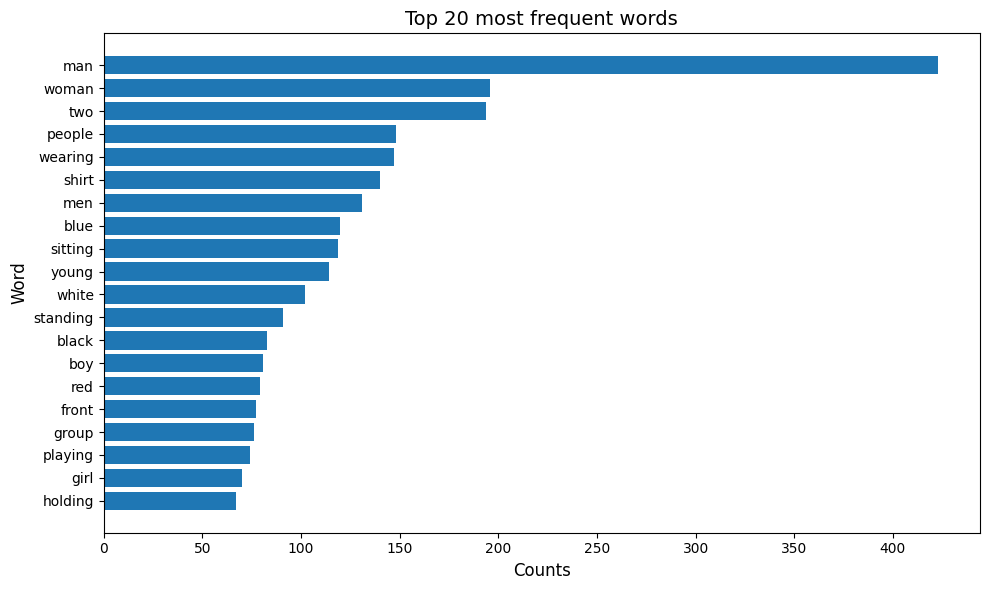

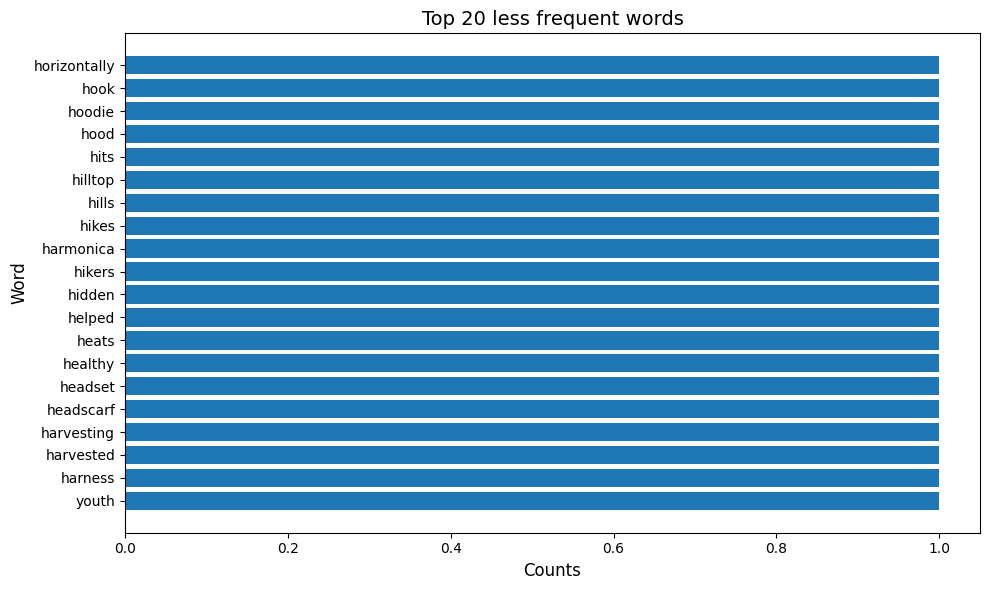

In [20]:
spacy_pos_tagged_data.groupby(["Tag type"]).size().reset_index(name='counts').sort_values('counts', ascending=False)
# NOUN - 4693

dfword = spacy_pos_tagged_data.groupby(["Word"]).size().reset_index(name='counts').sort_values('counts', ascending=False)
# man - 423
topn = 20

def plthist(dfsub, title=''):
    plt.figure(figsize=(10, 6))  # Adjust the figure size to make it more visually appealing
    plt.barh(dfsub["Word"], dfsub["counts"])  # Use horizontal bar plot for better readability
    plt.xlabel('Counts', fontsize=12)  # Add x-axis label
    plt.ylabel('Word', fontsize=12)  # Add y-axis label
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)  # Reduce the font size of x-axis ticks for better readability
    plt.title(title, fontsize=14)  # Increase the font size of the title
    plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent words on top
    plt.tight_layout()  # Adjust the spacing between the plot elements
    plt.show()

plthist(dfword.iloc[:topn, :], title="Top 20 most frequent words")
plthist(dfword.iloc[-topn:, :], title="Top 20 less frequent words")

## Named Entity Recognition

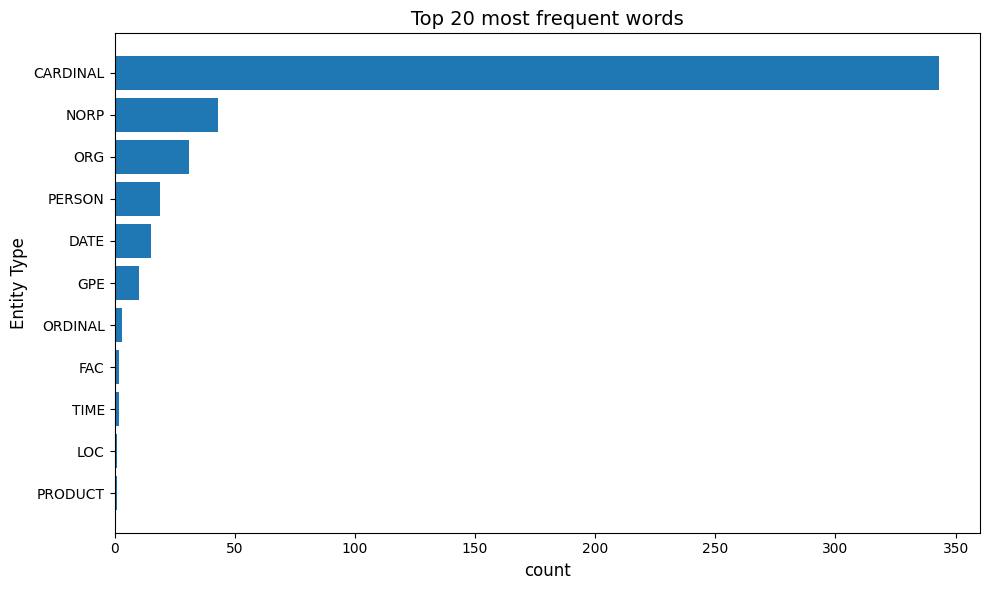

In [21]:
named_entities = []
for sentence in rawData['cleaned_cap1']:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities,
                            columns=['Entity Name', 'Entity Type'])
dfentity = entity_frame.groupby(['Entity Type']).size().reset_index(name='count').sort_values('count',ascending=False)

# print(dfentity)

def plthist(dfsub, title=''):
    plt.figure(figsize=(10, 6))  # Adjust the figure size to make it more visually appealing
    plt.barh(dfsub["Entity Type"], dfsub["count"])  # Use horizontal bar plot for better readability
    plt.xlabel('count', fontsize=12)  # Add x-axis label
    plt.ylabel('Entity Type', fontsize=12)  # Add y-axis label
    plt.yticks(fontsize=10)
    plt.xticks(fontsize=10)  # Reduce the font size of x-axis ticks for better readability
    plt.title(title, fontsize=14)  # Increase the font size of the title
    plt.gca().invert_yaxis()  # Invert the y-axis to show the most frequent words on top
    plt.tight_layout()  # Adjust the spacing between the plot elements
    plt.show()

plthist(dfentity.iloc[:topn, :], title="Top 20 most frequent words")

## Sentiment Analysis on Captions

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


{'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'compound': 0.34}
36979        1
65567        0
81641        0
134206       1
148284       0
            ..
110226481    0
110269384    0
110590591    0
110595925    0
110600869    1
Name: sentiment, Length: 1332, dtype: int64


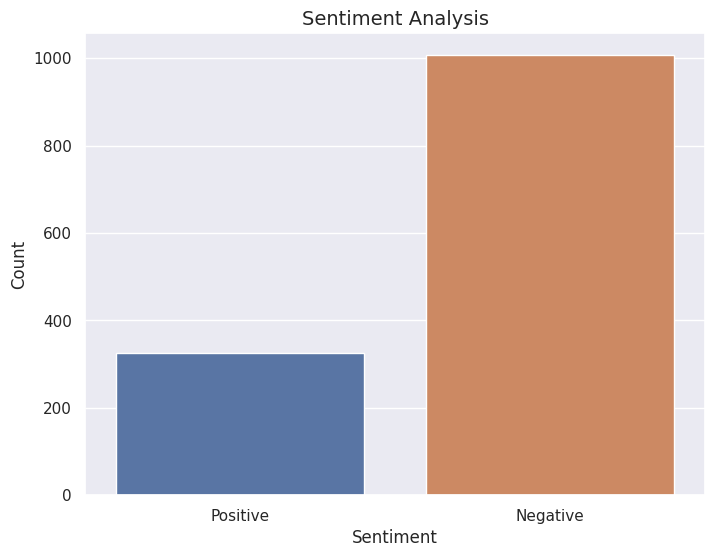

In [22]:
nltk.download('vader_lexicon')

import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
#Demo check on first row of the data
print(analyzer.polarity_scores(rawData['cleaned_cap1'][0]))

neg_count = 0
# function to return either 1 0r 0 for the pos score of the text
# function to return either 1 0r 0 for the pos score of the text
def get_sentiment(text):
  global neg_count
  scores = analyzer.polarity_scores(text)
  sentiment = 1 if scores['pos'] > 0 else 0
  neg_count=neg_count+scores['neg']
  return sentiment

### Adding new sentiment column to store either positive or zero value of the scores

rawData['sentiment'] = rawData['cleaned_cap1'].apply(lambda x :get_sentiment(x))

# Calculate the count of positive and negative tweets
print(rawData['sentiment'])
positive_tweets = rawData[rawData['sentiment'] == 1]['sentiment'].count()
negative_tweets = rawData[rawData['sentiment'] == 0]['sentiment'].count()

# Plot the sentiment analysis results
plt.figure(figsize=(8, 6))
sns.set(style="darkgrid")
sns.barplot(x=['Positive', 'Negative'], y=[positive_tweets, negative_tweets])
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Sentiment Analysis', fontsize=14)
plt.show()

As we did it succesfully we can print the images companied by their 5 descriptions, we will do this for the first 5 images in the dataset:

In [ ]:
# dir_imgs = "/content/drive/MyDrive/programs/datasets/train"
# for img in listdir(dir_imgs):
#   print(img,',')

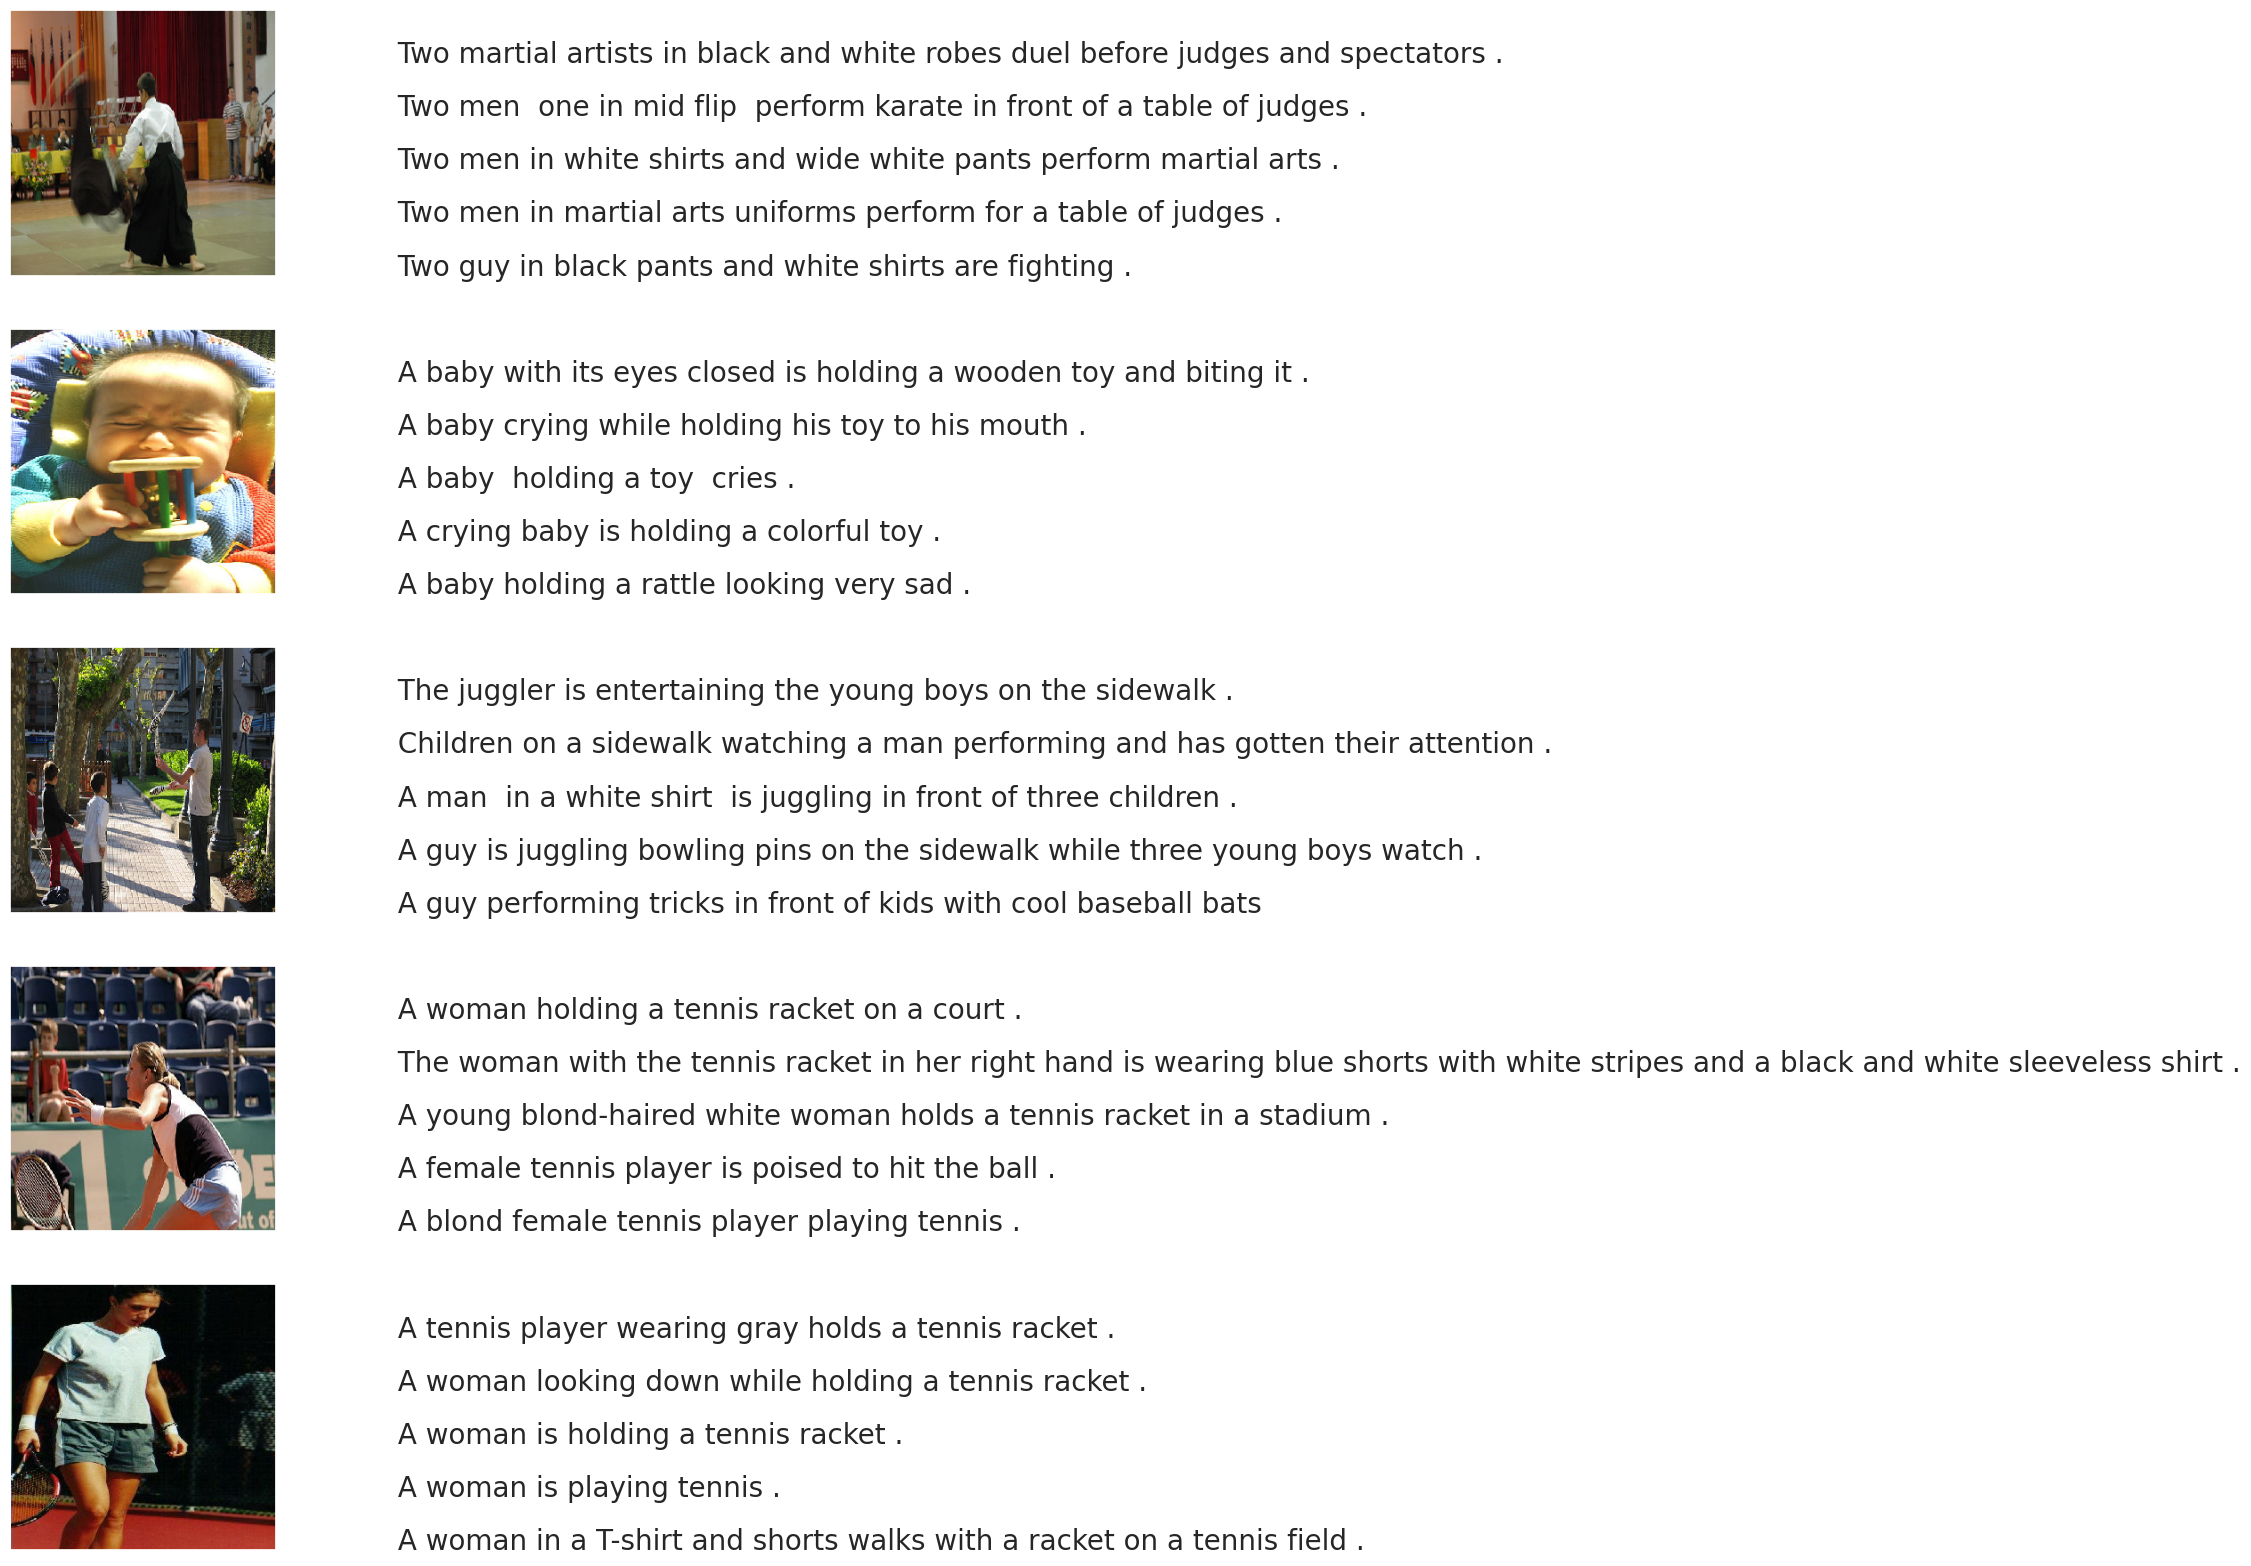

In [23]:
from tensorflow.keras.preprocessing.image import load_img

dir_descriptions = "/content/drive/MyDrive/datasets/caption/captions.txt"
dir_imgs = "/content/drive/MyDrive/datasets/data"
npix = 299
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for img in listdir(dir_imgs)[:5]:
    filename = dir_imgs + '/' + img
    captions = descriptions[img.split('.')[0]]
    image_load = load_img(filename, target_size=target_size)

    ax = fig.add_subplot(5, 2, count, xticks=[], yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(5, 2, count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

Plotting the top most frequent words and least frequent words

Text cleaning : removing punctuations,lowering text.

In [24]:
import string

def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        #for i in range(len(desc_list)):
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)


# Making use of the function just created
clean_descriptions(descriptions)

In [25]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 4925


The following step can be considered as a milestone because this will change the performance of the model depending on your resources. Here we will save in a .txt file comprehending two objects per line the image id with one description, therefore 5 lines will take the descriptions of each image. Later we will see that when we consider these it crashes our compute engine because it requires higher RAM, because of this we will consider only 2 captions for each image:

In [26]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        #for desc in desc_list:   # If you have RAM higher than 16GB uncomment this line
        for desc in desc_list[:2]:  # This will make our program to save only 2 captions per image
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

# save descriptions
save_descriptions(descriptions, 'descriptions.txt')

As the dataset is splitted into training, development and testing sets we have to define a couple of functions more to make the process of gathering such sets easier.

The following function will help us get the ids of all images contained in the directory we specify and return it as a list:

In [27]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

Once we have all ids of images containing in a specific set the following function will retrieve the descriptions from the *descriptions.text* file for such images and wrap them properly including start and end of sequence tokens:

In [28]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

Similar to the above function the following one will retrieve the image features from the *features.pkl* file corresponding to all images contained in a specific set.

In [29]:
# load photo features
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename, 'rb'))
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

The next couple of functions have the simple purpose of tokenizing the descriptions given:

In [30]:
from keras.preprocessing.text import Tokenizer

# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

The max_length function below computes the length of all descriptions in the dataset and retrieves the longest one, which in this dataset corresponds to 34 words, however as we will pad all sequences to such length it will definitely require a much higher RAM, later we will see why we didn't use this function and instead just set to 17 words.

In [31]:
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

Finally, the function which makes our machine to crash, this creates the sequences given te tokenizer created, max length, set of descriptions, image features and vocabulary size.

In [32]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, descriptions, photos, vocab_size):
    X1, X2, y = list(), list(), list()
    # walk through each image identifier
    for key, desc_list in descriptions.items():
        # walk through each description for the image
        for desc in desc_list:
            # encode the sequence
            seq = tokenizer.texts_to_sequences([desc])[0]
            # split one sequence into multiple X,y pairs
            for i in range(1, len(seq)):
                # split into input and output pair
                in_seq, out_seq = seq[:i], seq[i]
                # pad input sequence
                in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                # encode output sequence
                out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                # store
                X1.append(photos[key][0])
                X2.append(in_seq)
                y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

The following creates the model we are going to work with, notice it was build using the functional API and contains two branches the CNN and LSTM, then the decoder recieves the output of these and computes the next word of the caption as a classification task with a layer with number of neurons equal to the vocabulary size.

In [33]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor model
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)  #Default 256
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 128, mask_zero=True)(inputs2)    #Default 256
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(128)(se2)     #Default 256
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(128, activation='relu')(decoder1)      #Default 256
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

We can see the model architecture in the image created named *model.png* so go and open it if you have any doubts or have any idea on how to improve it.

## Train dataset

Dataset: 1132
Descriptions: train=1132
Photos: train=1132
Vocabulary Size: 3084
Description Length: 17


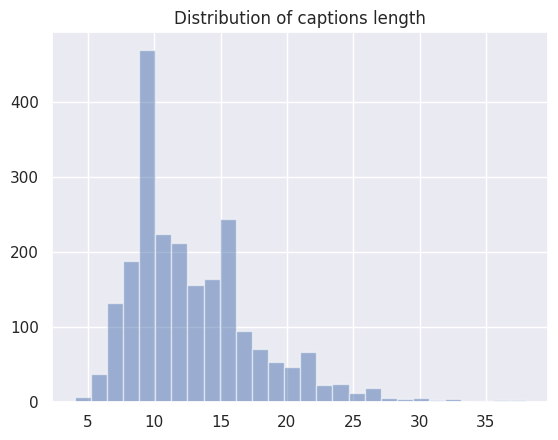

In [34]:
from pickle import load

# load training dataset (6K)
filename = '/content/drive/MyDrive/datasets/train/train.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

# descriptions
train_descriptions = load_clean_descriptions('./descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

# photo features
train_features = load_photo_features('./features.pkl', train)
#train_features = load(open('./features.pkl', 'rb'))
print('Photos: train=%d' % len(train_features))

# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

# determine the maximum sequence length
#max_length = max_length(train_descriptions)
max_length=17
print('Description Length: %d' % max_length)

lengths=[]
lines = to_lines(train_descriptions)
for d in lines:
    lengths.append(len(d.split()))

plt.hist(lengths, bins=28, alpha=0.5)
plt.title('Distribution of captions length')
plt.show()

# prepare sequences
X1train, X2train, ytrain = create_sequences(tokenizer, max_length, train_descriptions, train_features, vocab_size)

As we can see above the distribution of captions length follows a bell-shape curve with a slight right skew. This means there is a significant percentile comprehended in the lower numbers of the x-axis and this was the reason why I choose 17, because larger descriptions happen hardly ever. Obviously, you can choose a higher number, but this will definitely require higher computing resources.

## Test Dataset

In [35]:
# load test set
filename = "/content/drive/MyDrive/datasets/test/test.txt"
dev = load_set(filename)
print('Dataset: %d' % len(dev))
# descriptions
dev_descriptions = load_clean_descriptions('./descriptions.txt', dev)
print('Descriptions: test=%d' % len(dev_descriptions))
# photo features
dev_features = load_photo_features('./features.pkl', dev)
print('Photos: test=%d' % len(dev_features))
# prepare sequences
X1dev, X2dev, ydev = create_sequences(tokenizer, max_length, dev_descriptions, dev_features, vocab_size)

Dataset: 100
Descriptions: test=100
Photos: test=100


## Model Definition

In [36]:
# # define the model
# model = define_model(vocab_size, max_length)
# # define checkpoint callback
# filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
# #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# # fit model
# model.fit([X1train, X2train], ytrain, epochs=20, verbose=1, callbacks=[checkpoint], validation_data=([X1dev, X2dev], ydev))

# Define empty lists to store loss and validation loss
loss_history = []
val_loss_history = []

# Define the model
model = define_model(vocab_size, max_length)

# Define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

# Define a custom callback to store loss and val_loss
class LossHistoryCallback(tensorflow.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_history.append(logs['loss'])
        val_loss_history.append(logs['val_loss'])

# Fit the model
history = model.fit([X1train, X2train], ytrain, epochs=20, verbose=1, callbacks=[checkpoint, LossHistoryCallback()], validation_data=([X1dev, X2dev], ydev))


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 17)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 17, 128)      394752      ['input_3[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 2048)         0           ['input_2[0][0]']                
                                                                                              

Epoch 1/20
841/841 [==============================] - ETA: 0s - loss: 5.8281
Epoch 1: saving model to model-ep001-loss5.828-val_loss5.260.h5
841/841 [==============================] - 68s 74ms/step - loss: 5.8281 - val_loss: 5.2598
Epoch 2/20
841/841 [==============================] - ETA: 0s - loss: 5.1199
Epoch 2: saving model to model-ep002-loss5.120-val_loss4.999.h5
841/841 [==============================] - 60s 72ms/step - loss: 5.1199 - val_loss: 4.9986
Epoch 3/20
841/841 [==============================] - ETA: 0s - loss: 4.7512
Epoch 3: saving model to model-ep003-loss4.751-val_loss4.902.h5
841/841 [==============================] - 60s 72ms/step - loss: 4.7512 - val_loss: 4.9020
Epoch 4/20
841/841 [==============================] - ETA: 0s - loss: 4.4853
Epoch 4: saving model to model-ep004-loss4.485-val_loss4.871.h5
841/841 [==============================] - 60s 71ms/step - loss: 4.4853 - val_loss: 4.8713
Epoch 5/20
841/841 [==============================] - ETA: 0s - loss: 4.

## Training vs Validation Loss

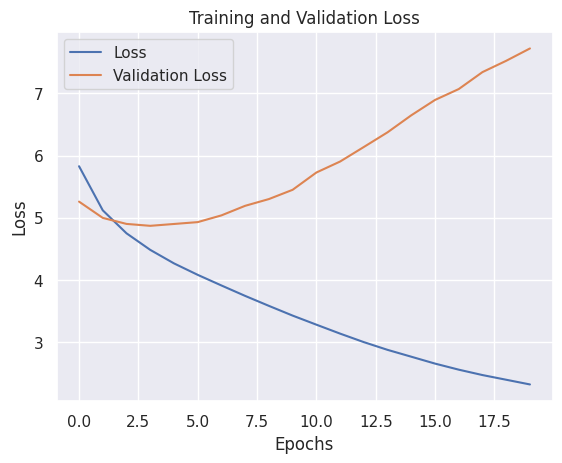

In [47]:
import matplotlib.pyplot as plt

# Plot loss and validation loss
plt.plot(loss_history, label='Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Generate caption for an image

In [38]:
# map an integer to a word
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length)
        # predict next word
        yhat = model.predict([photo,sequence], verbose=0)
        # convert probability to integer
        yhat = np.argmax(yhat)
        # map integer to word
        word = word_for_id(yhat, tokenizer)
        # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
    return in_text

## Accuracy test using BLEU Score

In [48]:
from nltk.translate.bleu_score import corpus_bleu

# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [49]:
# load test set
filename = '/content/drive/MyDrive/datasets/test/test.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('./descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('./features.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 100
Descriptions: test=100
Photos: test=100


In [50]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
# save the tokenizer
dump(tokenizer, open('tokenizer.pkl', 'wb'))

## Caption an Image

1/1 [==============================] - 1s 1s/step
startseq man in blue shirt is standing on scaffolding endseq


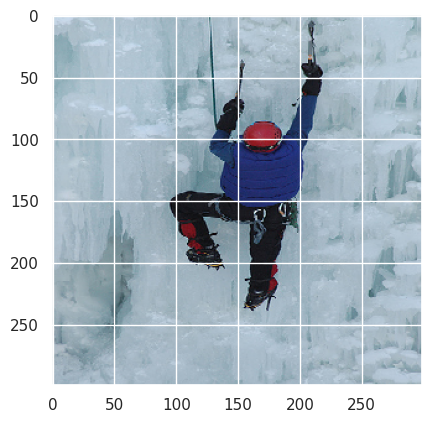

In [56]:
from keras.models import load_model
from keras.applications.xception import preprocess_input
import matplotlib.pyplot as plt

# Load the Xception model
model_Xception=Sequential()
model_Xception.add(Xception(include_top=False,
                            weights='imagenet',
                            pooling='max'))

model_Xception.add(Dropout(0.2))
model_Xception.add(Dense(2048,activation='relu'))


# Load the language model
tokenizer = create_tokenizer(train_descriptions)  # Replace with the actual initialization of your tokenizer
model = load_model('./model-ep020-loss2.325-val_loss7.719.h5')

# Load and prepare the photograph
image_path = "/content/drive/MyDrive/datasets/data/102455176.jpg"  # Replace with the path to your image
image = load_img(image_path, target_size=(299, 299))
plt.imshow(image)

# Convert the image pixels to a numpy array
image = img_to_array(image)

# Reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# Prepare the image for the Xception model
image = preprocess_input(image)

# Get features
photo_features = model_Xception.predict(image, verbose=1)

# Generate description
max_length = 17  # Set the appropriate sequence length for the model's input
description = generate_desc(model, tokenizer, photo_features, max_length)
print(description)


## BLEU Score

In [58]:
from nltk.translate.bleu_score import corpus_bleu

# Evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # Step over the whole set
    for key, desc_list in descriptions.items():
        # Generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # Store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    # Calculate BLEU score
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0))
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25))

    return bleu1, bleu2, bleu3, bleu4

# Load the model
filename = './model-ep020-loss2.325-val_loss7.719.h5'
model = load_model(filename)

# Evaluate model
bleu1, bleu2, bleu3, bleu4 = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

# Print the accuracy scores
print('BLEU-1: %f' % bleu1)
print('BLEU-2: %f' % bleu2)
print('BLEU-3: %f' % bleu3)
print('BLEU-4: %f' % bleu4)


BLEU-1: 0.362330
BLEU-2: 0.149124
BLEU-3: 0.095376
BLEU-4: 0.000000


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
